# Vacant Threshold test

In [3]:
import random
import numpy
from datetime import datetime
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.detector.OccupancyDetectorDiff import OccupancyDetectorDiff
import cv2 as cv
import os
import pickle

# metrics_list = list()
# row_names = list()
random_seed = 1
# random_seed = datetime.now().timestamp
 
def test_parking(parking_id, weather, detection_params:DetectionParams, row_name, process_batch=True, training=False):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    training_test_folder = 'training' if training else 'test'
    provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path=f'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\dataset\\{training_test_folder}\\{parking_id}\\{weather}')
    
    processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    detection_params.parking_id = parking_id
    detection_params.weather = weather
    
    if process_batch:
        try:
            detection_params.show_imshow=False
            processor.process_batch()
        except (NoSpacesException, NoImageException) as ex:
            print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                processor.process()
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
        
    metrics_provider.calculate_metrics()
    plot = not training
    metrics_provider.show_confusion_matrix(plot)

    return metrics_provider.metrics
    # metrics_list.append(metrics_provider.metrics)
    # row_names.append(row_name)
    
def test_vacant_threshold(parking_id, weather, detection_params:DetectionParams, diff_threshold_list, vacant_threshold_list, training=False):
    detection_params.weather = weather
    metrics_dict_vt = dict()
    
    for vacant_threshold in vacant_threshold_list:
        metrics_dict_diff = dict()
        
        for diff_threshold in diff_threshold_list:    
            row_name = f'{parking_id}-{weather} vt={vacant_threshold} diff_t={diff_threshold}'
            print('Testing ', row_name)
            
            detection_params.vacant_threshold = vacant_threshold
            detection_params.diff_threshold = diff_threshold
            metrics = test_parking(parking_id, weather, detection_params, row_name, True, training)
            
            metrics_dict_diff[diff_threshold] = metrics

        metrics_dict_vt[vacant_threshold] = metrics_dict_diff
         
    return metrics_dict_vt
    # PerformanceMetricsProviderSklearn.show_dataframe(metrics_list, row_names)
        
def setup_params(parking_id, weather, initial_params:DetectionParams=None):
   
    provider_params = ParkingProviderLocalParams(
        parking_id=parking_id, path=f'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\{parking_id}\\{weather}', k=200)

    parking_provider = ParkingProviderLocal(provider_params)

    # metrics: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    # processor = ParkingOccupancyProcessorLocal(
    #     parking_provider_params=provider_params, detection_params=PARAMS_UFPR04, performance_metrics_provider=metrics)

    try:
        params = initial_params
        while True:
        # while (it > 0 and i < it) or it < 0:
        #     i = i+1
        #     print(f"Processing sample: {str(i)}")
        #     processor.process()

            parking = parking_provider.get_parking()
            img = parking.image
            spaces = parking.spaces

            params = OccupancyDetectorDiff.setup_params_img(img, parking_id, weather, spaces, params)

            cv.namedWindow("Press ESC to exit, other key to continue")
            key = cv.waitKey(0)
            if key == 27:
                cv.destroyAllWindows()
                break  
              
            cv.destroyAllWindows()
   
    except (NoSpacesException, NoImageException) as ex:
        print(f"Finished processing: ", ex)
    finally:
        return params
    
def calculate_metrics(params, parking_id, weather_list, diff_threshold_list, vacant_threshold_list, training=True, show_metrics=True, save_fig_dst=None):
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:
        
        file_pickle = f"test/metrics/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"
        if not os.path.exists(file_pickle):
            metrics_dict_vt = test_vacant_threshold(parking_id, weather, params, diff_threshold_list, vacant_threshold_list, training)
        else:
            with open(file_pickle, 'rb') as f:
                metrics_dict_vt = pickle.load(f)
                
        # Saving the objects:   
        if not os.path.exists(file_pickle):
            f= open(file_pickle, 'wb')
            pickle.dump(metrics_dict_vt, f)


        if show_metrics:
            fig_dst = save_fig_dst + f'{parking_id}_{weather}_{training_test_folder}.png'
            PerformanceMetricsProviderSklearn.show_tpr_fpr(metrics_dict_vt,parking_id, weather, show_diff=True, save_fig_dst=fig_dst)
    


## UFPR04

In [ ]:
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=True)  # UFPR04
PARAMS_UFPR04.vacant_threshold = 0.3
PARAMS_UFPR04.diff_threshold = 50

parking_id = 'UFPR04'
weather = 'Sunny'
row_name = f'{parking_id}-{weather}'

 
test_parking(parking_id, weather, PARAMS_UFPR04, row_name, True)

In [2]:
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=False)  # UFPR04
vacant_threshold_list = [0.45, 0.4, 0.35, 0.30, 0.25, 0.2]
diff_threshold_list = [35,40,45,50,55,60]
parking_id = 'UFPR04'
weather_list = ['Cloudy', 'Sunny', 'Rainy']
training = True

calculate_metrics(PARAMS_UFPR04, parking_id, weather_list, diff_threshold_list, vacant_threshold_list, training, show_metrics=True)

NameError: name 'DetectionParams' is not defined

# UFPR05

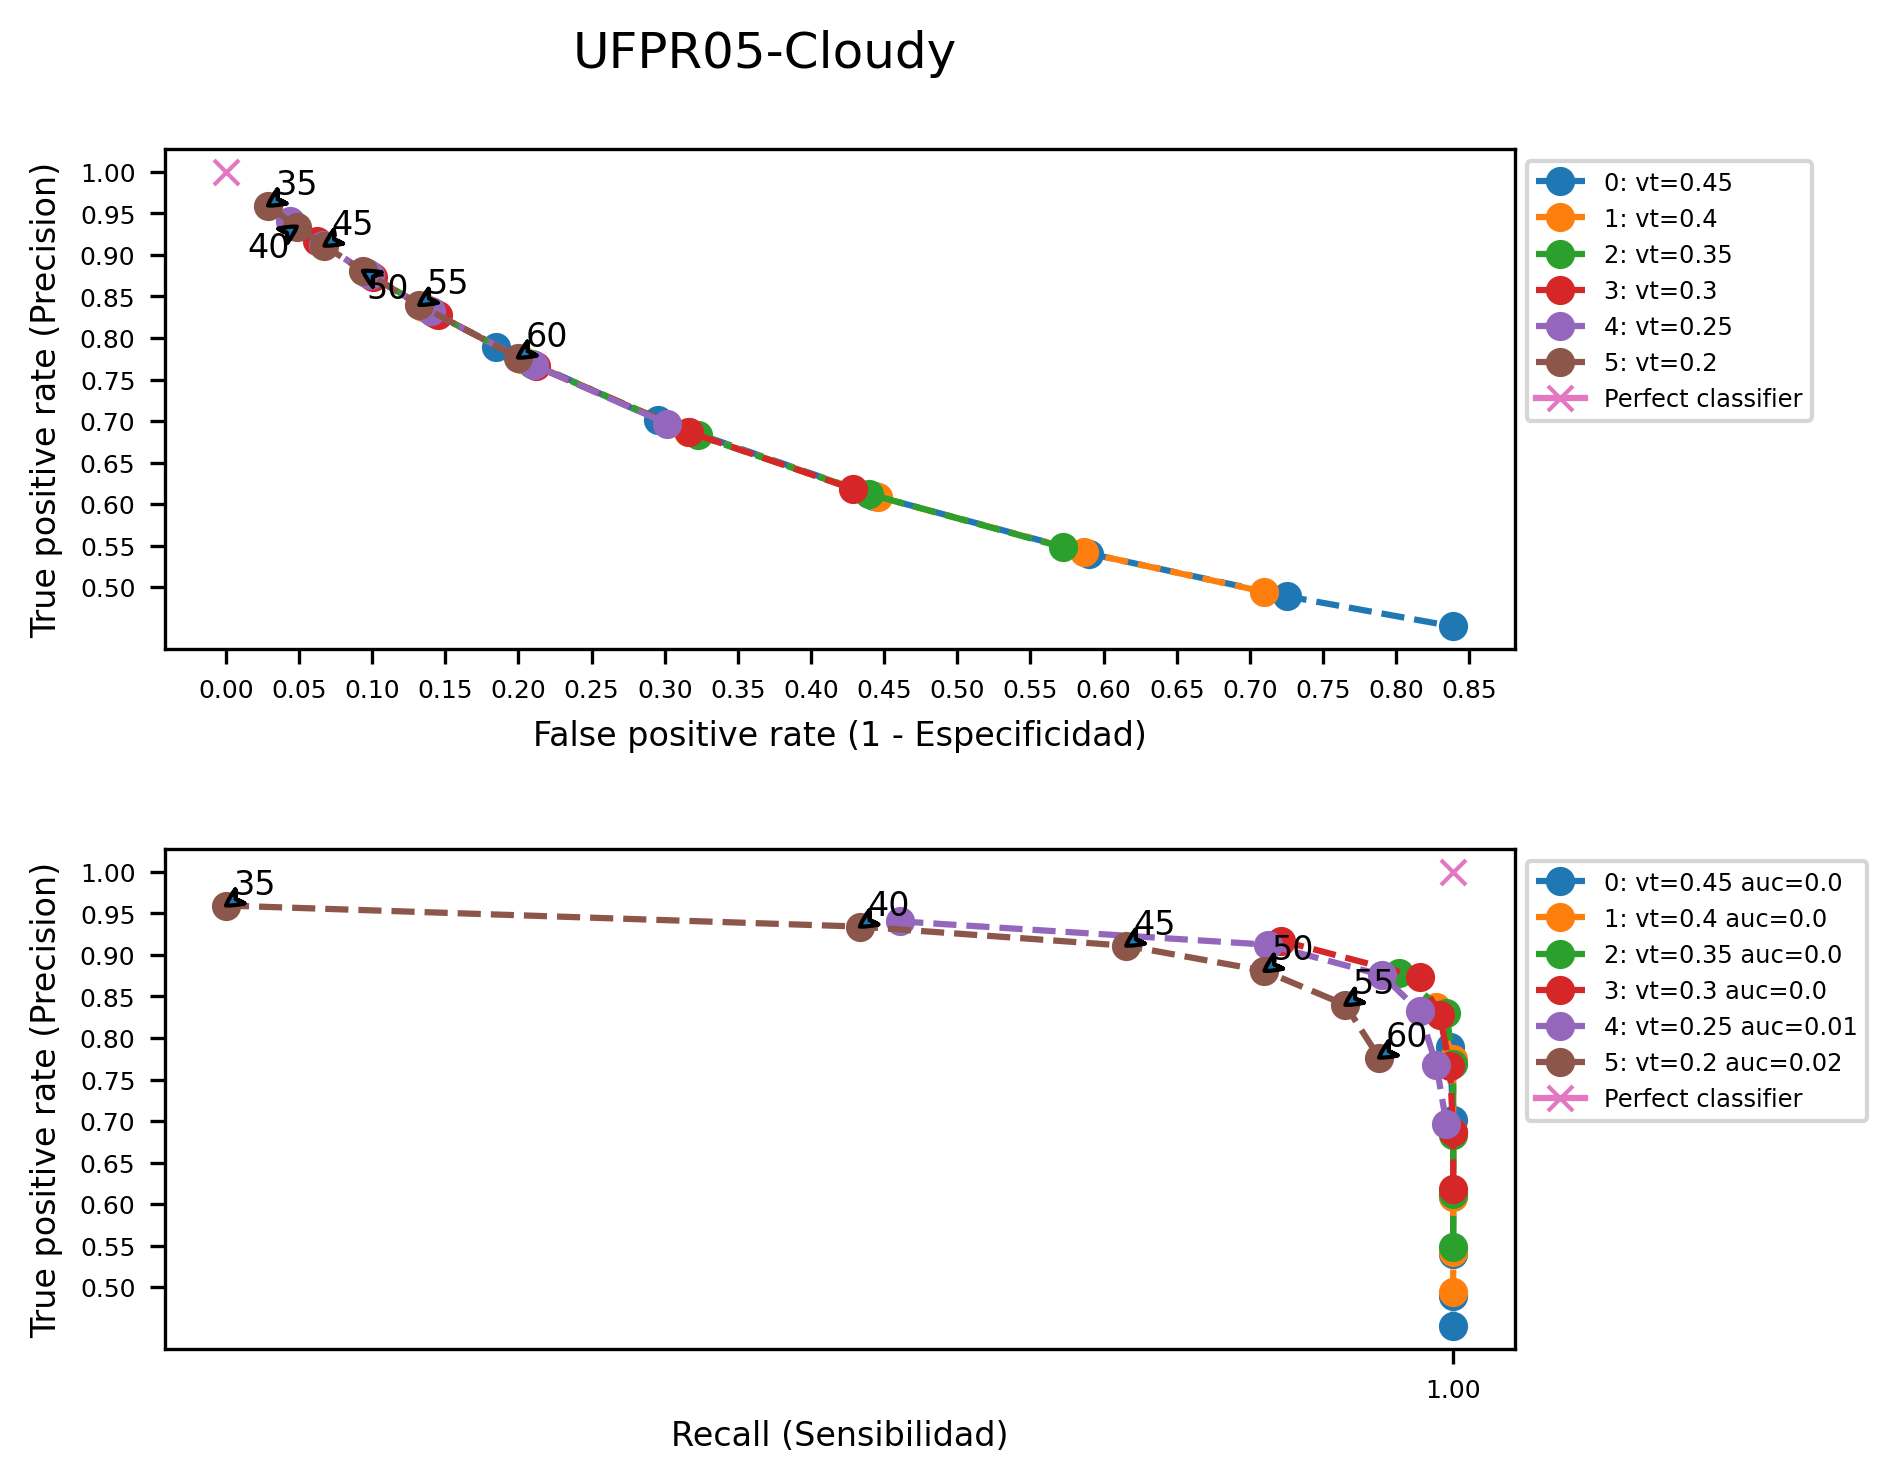

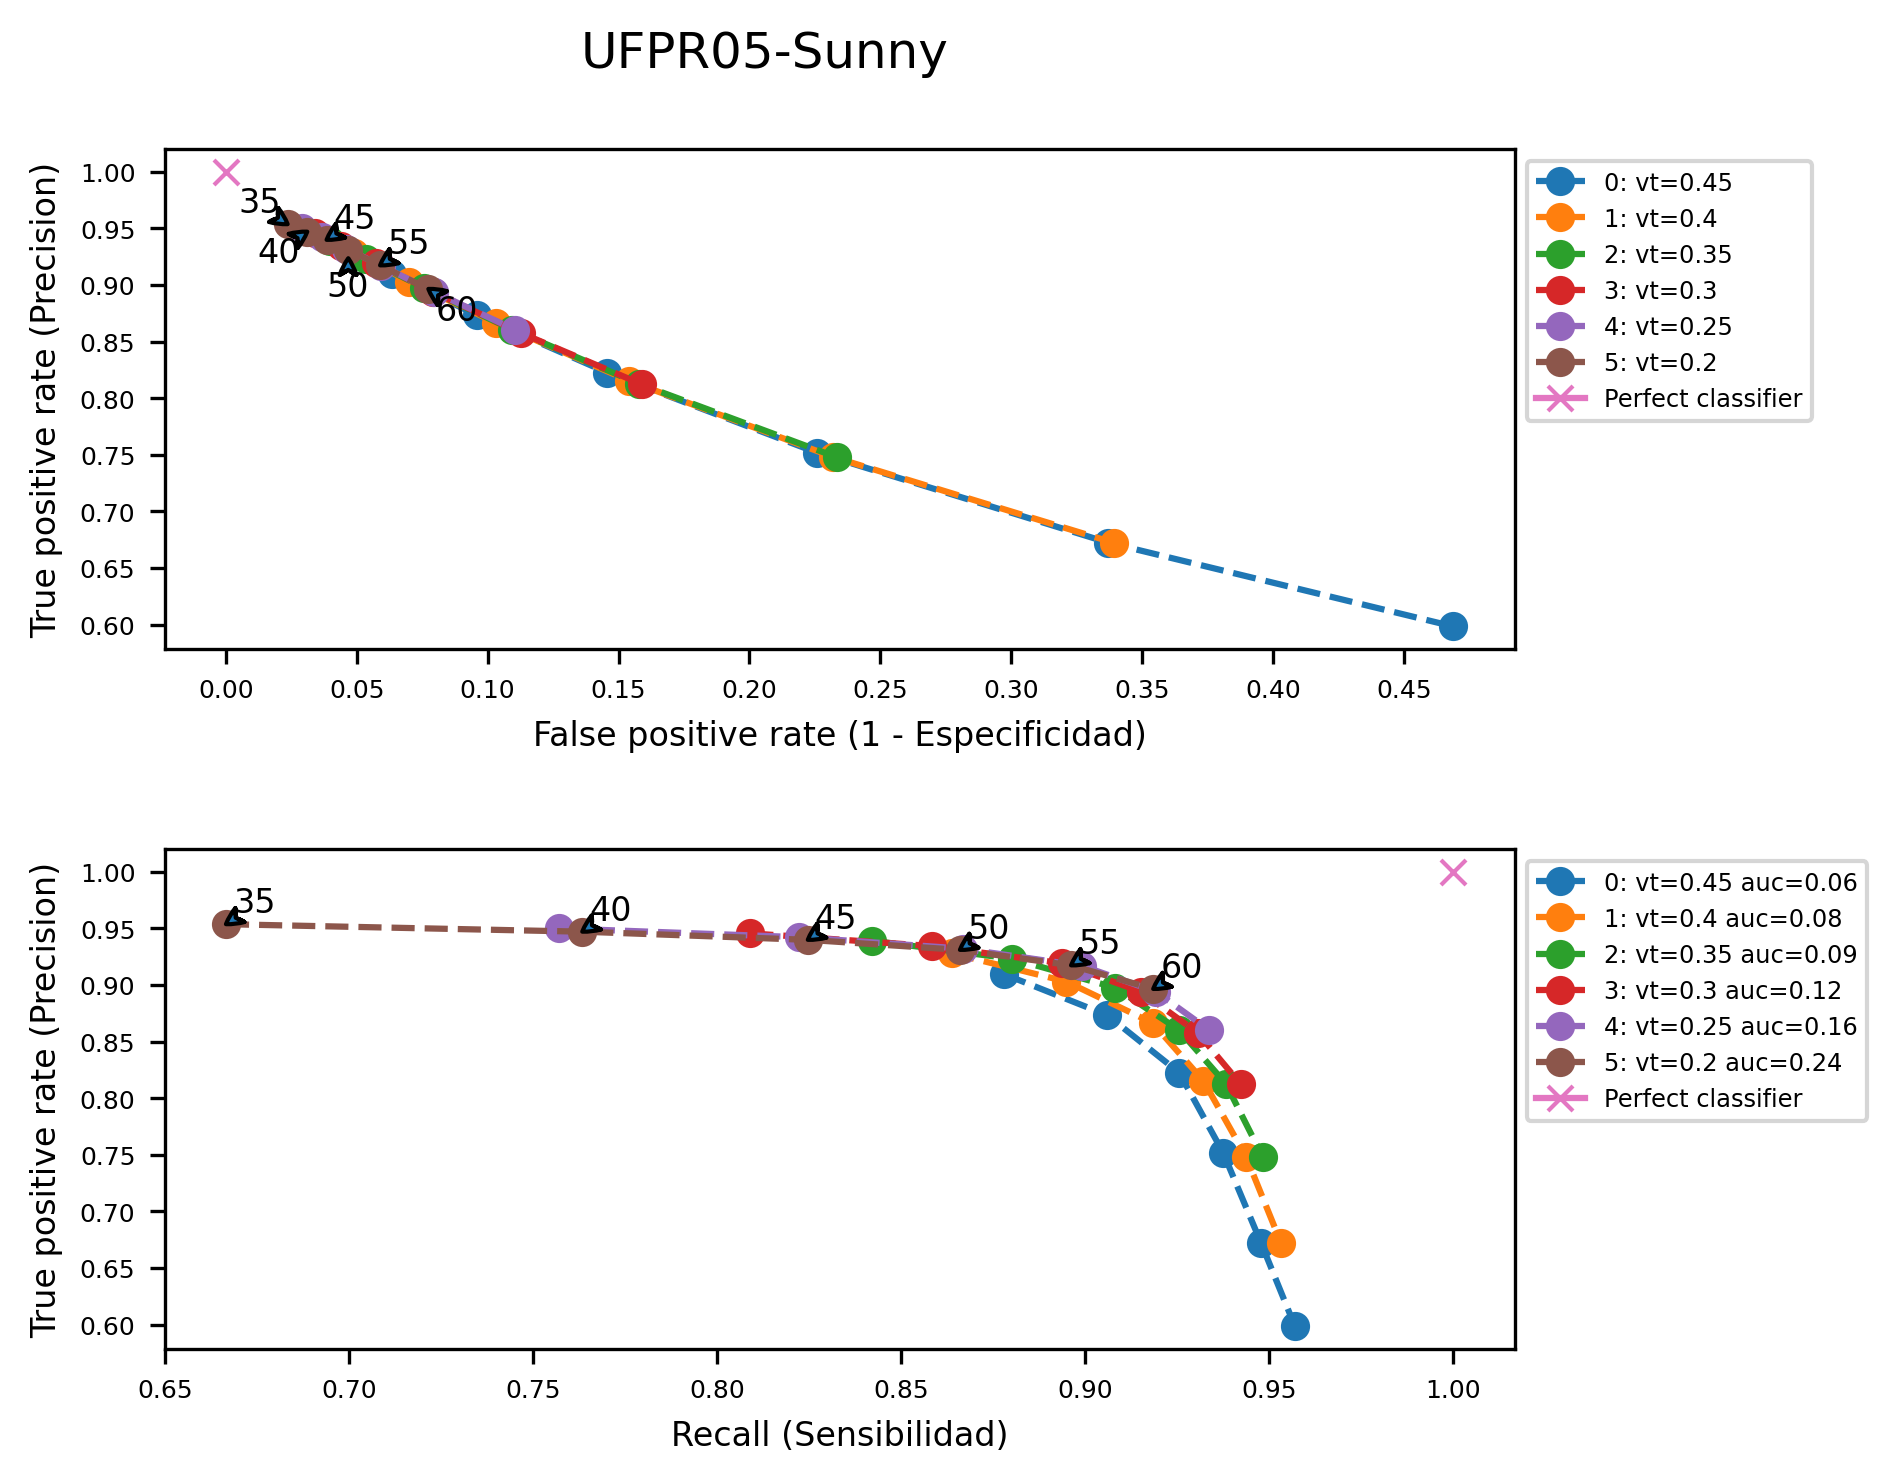

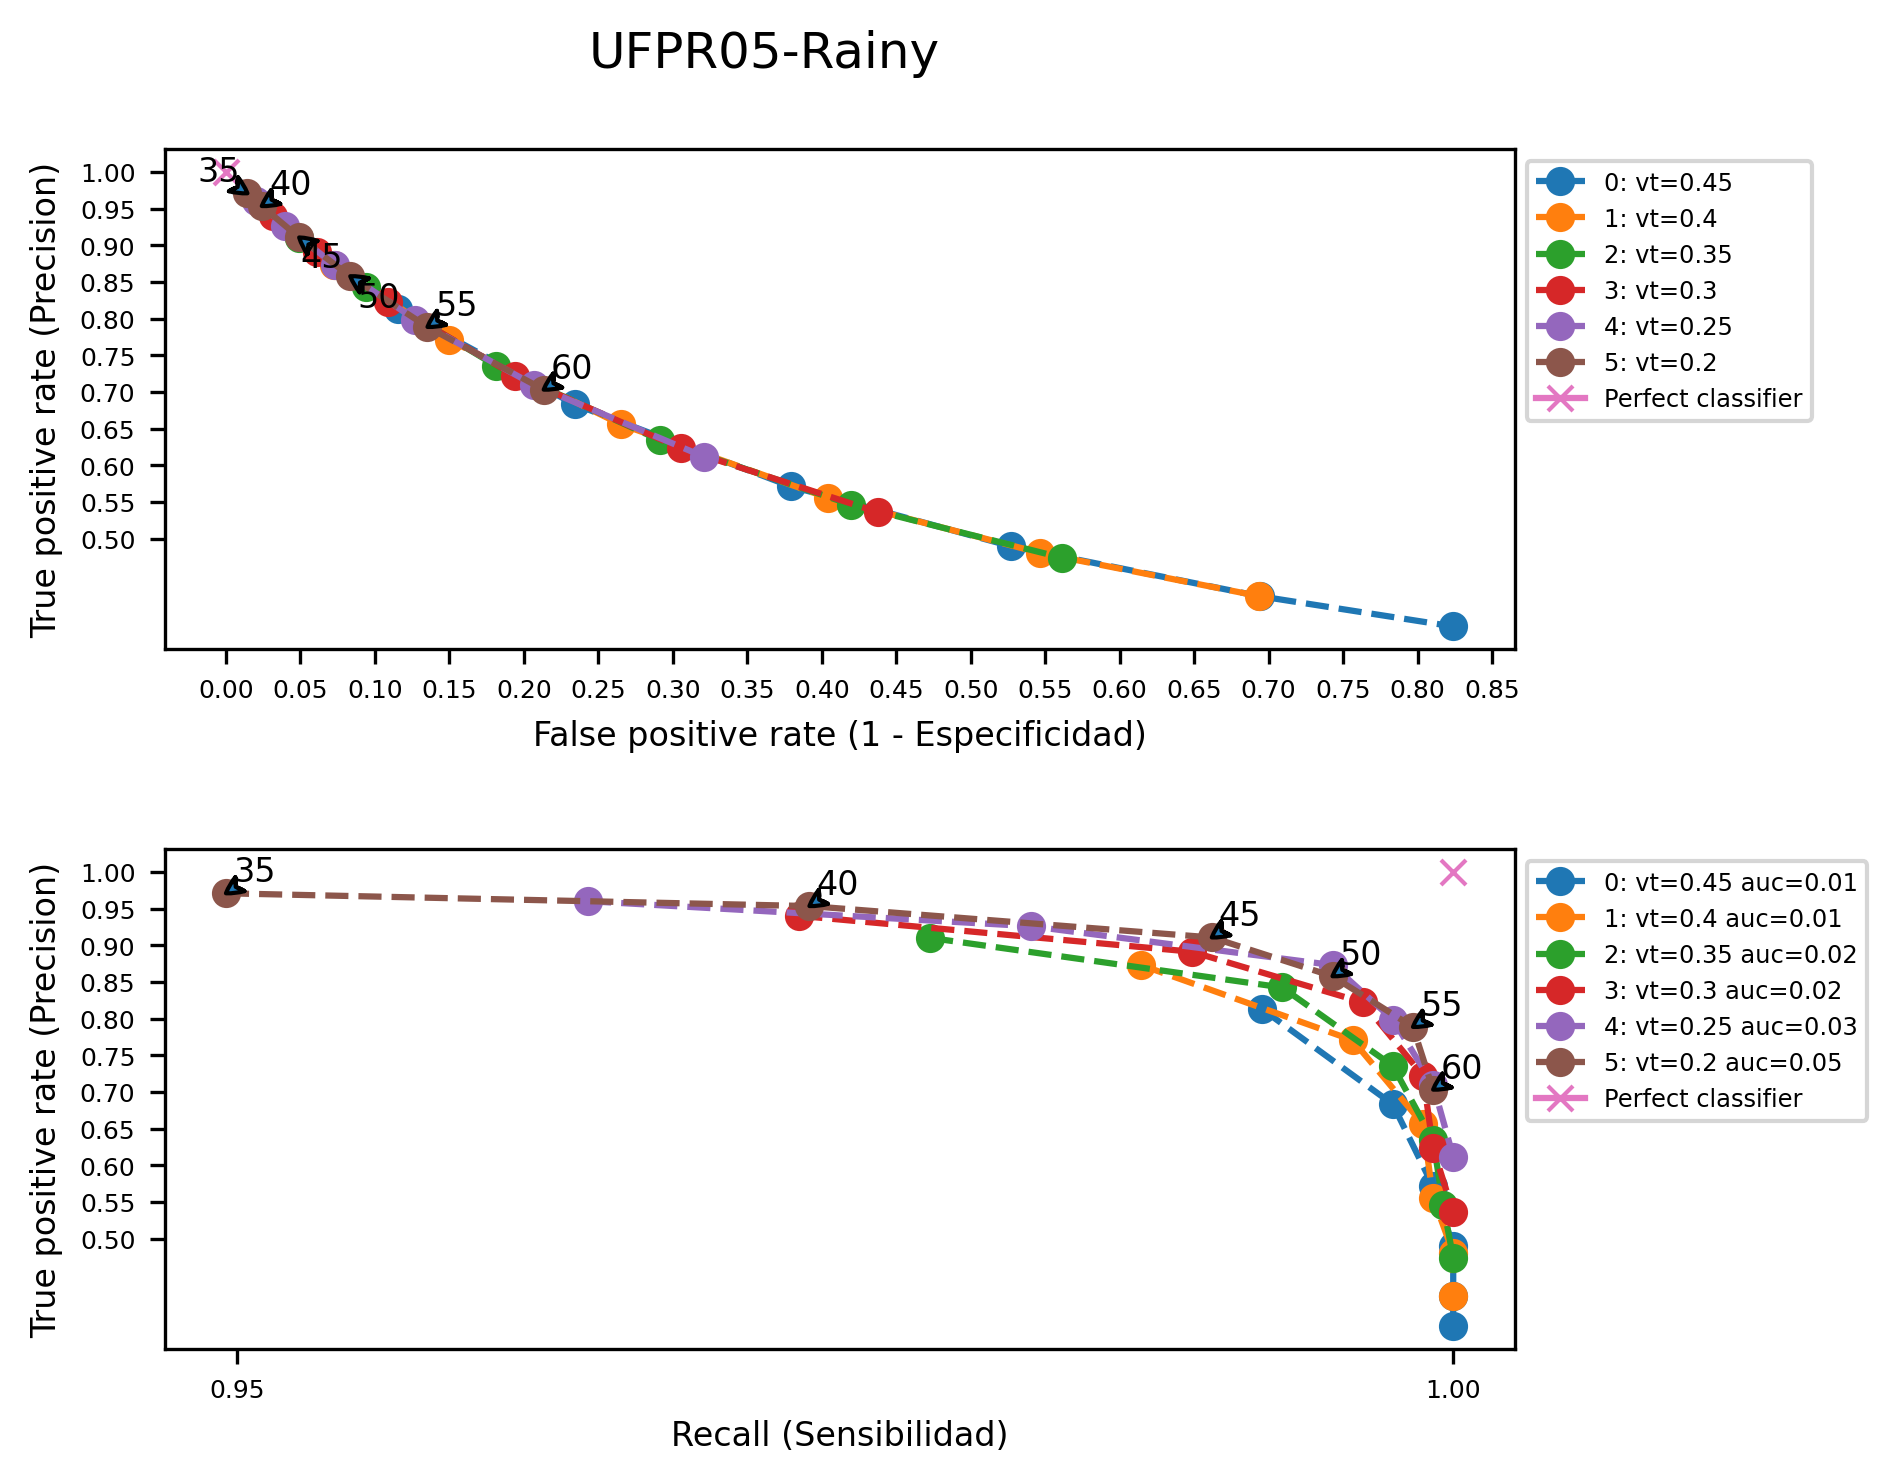

In [4]:
import pickle
PARAMS_UFPR05 = DetectionParams(gb_k=(3,3), gb_s=0, median_k=3, bw_size=20, show_imshow=False)
PARAMS_PUCPR = DetectionParams(gb_k=(5, 5), gb_s=0, median_k=3, bw_size=85, show_imshow=False)
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=False)

vacant_threshold_list = [0.45, 0.4, 0.35, 0.30, 0.25, 0.2]
diff_threshold_list = [35,40,45,50,55,60]
parking_id = 'UFPR05'
weather_list = ['Cloudy', 'Sunny', 'Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'

calculate_metrics(PARAMS_UFPR05, parking_id, weather_list, diff_threshold_list, vacant_threshold_list, training, show_metrics=True, save_fig_dst=save_dst)